In [1]:
from tensorflow.python.client import device_lib
devices=device_lib.list_local_devices()
def sizeof_fmt(num,suffix='B'):
    for unit in ['','Ki','Mi','Gi', 'Ti', 'Pi','Ei','Zi']:
        if abs(num)<1024.0:
            return "%3.1f %s%s" %(num, unit, suffix)
        num/=1024.0
    return "%.1f%s%s" %(num, 'Yi', suffix)
for d in devices:
    t=d.device_type
    name=d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len (x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  Quadro RTX 6000 || GPU || 21.7 GiB


In [2]:
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import top_k_categorical_accuracy
from scipy.ndimage import zoom
from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
tf.compat.v1.enable_eager_execution()

In [3]:
def CstmNet(input_shape=(128, 128, 64, 1)):

    X1_input = Input(input_shape)
    

    X1 = Conv3D(32, (9, 9, 9), strides=1, name='conv3', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1_input)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(6, strides=6)(X1) 
    
    X1 = Conv3D(32, (6, 6, 6), strides=1, name='conv2', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(3, strides=3)(X1) 


    X1 = Conv3D(16, (3, 3, 3), strides=1, name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(3, strides=2)(X1)   
      
           
    X = Flatten()(X1)
    
############ Final Layer ######################
    
#     X = Dense(512, activation='relu', name='fc1', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = Dropout(0.1)(X)
    X = Dense(256, activation='relu', name='fc2', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(0.2)(X)
    X = Dense(128, activation='relu', name='fc3', kernel_initializer=glorot_uniform(seed=0))(X)
    drop = Dropout(0.2)(X)
    output = Dense(1, activation='sigmoid', name='fc5',kernel_initializer=glorot_uniform(seed=0))(drop) 
    model = Model(inputs=[X1_input], outputs=output, name='CstmNet')
    
    return model

model = CstmNet(input_shape=(128, 128, 64, 1))
model.summary()

Model: "CstmNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3 (Conv3D)              (None, 128, 128, 64, 32)  23360     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64, 32)  128      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 21, 21, 10, 32)   0         
 )                                                               
                                                           

In [6]:
import nibabel as nib
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image = nib.load(image_path)
            img = image.get_fdata()
            img = zoom(img, (0.533, 0.533, 0.413)) 
            img [img<0] = 0
            img_nor = img / np.max(img)
            img_nor = img_nor.astype(np.float32)
            
            img_data_array.append(img_nor)
            class_name.append(dir1)
    return img_data_array, class_name

# extract the image array and class name

img_test, class_test =create_dataset(r'C:\\Dhruba Research Drive\\External for binary\\Class_enhCE')
#img_test, class_test =create_dataset(r'C:\\Dhruba Research Drive\\Binary classification\\enh\\fold1')
####################################################################################################

target_dict_test={k: v for v, k in enumerate(np.unique(class_test))}
target_val_test=  [target_dict_test[class_test[i]] for i in range(len(class_test))]
print(target_dict_test)


#######################################################################################################
### Enh_CE tumor Shape
## For Test Set ###
x_test=np.array(img_test, np.float32)
y_test=np.array(list(map(int,target_val_test)), np.float32)
X_test = np.expand_dims(x_test, axis=4)

print("################ Enh_CE tumor shapes #####################")
print(X_test.shape)
print(y_test.shape)

{'GBM': 0, 'Mets': 1}
################ Enh_CE tumor shapes #####################
(59, 128, 128, 64, 1)
(59,)


In [3]:
classification_model = load_model('CstmNt_exter_enhCE_2class.epoch08-acc0.90.hdf5', compile = False)

In [4]:
classification_model.summary()

Model: "CstmNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3 (Conv3D)              (None, 128, 128, 64, 32)  23360     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64, 32)  128      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 21, 21, 10, 32)   0         
 )                                                               
                                                           

In [7]:
y_pred = classification_model.predict(x=X_test, batch_size = 25)

3/3 [==============================] - 5s 470ms/step


In [8]:
y_pred.shape

(59, 1)

(128, 128, 64, 1)
(128, 128, 1)


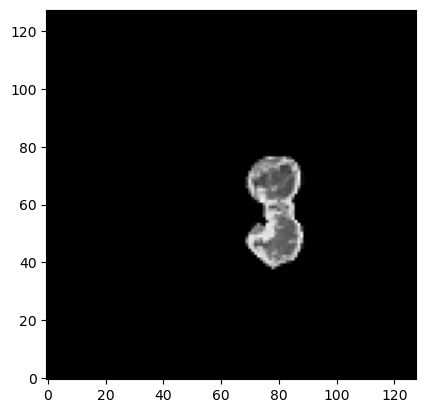

In [9]:
img = X_test[0]
print(img.shape)
sli = img[:, :, 35]
print(sli.shape)
vol = np.transpose(sli, (2, 1, 0))
vol = vol[0, :, :]
plt.imshow(vol, origin='lower', cmap='gray')

In [10]:
## Function to Resize the 3D volume ##

def resize_image_with_crop_or_pad(image, img_size=(128, 128, 64), **kwargs):

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer], to_padding, **kwargs)

In [10]:
from scipy import ndimage

In [11]:
LAYER_NAME = 'conv1'
grad_model = tf.keras.models.Model([classification_model.inputs], [classification_model.get_layer(LAYER_NAME).output, classification_model.output])

Text(0.5, 1.0, 'Overlay')

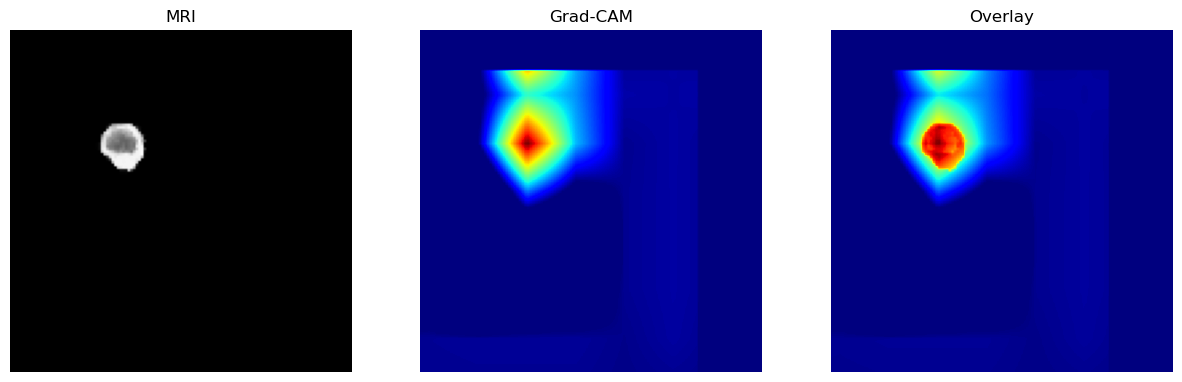

In [70]:
###### Loading volume and compute the gradients
##----Load---Image
from skimage.transform import resize

img_num = 8 #total 59 images, 0-58

image= X_test[img_num]
resized_img=image[:,:,:,0]

#resized_img.shape
io_img=image
io_img=tf.expand_dims(io_img, axis=0)

###----index of the class
CLASS_INDEX=0

###--Compute GRADIENT
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(io_img)
    loss = predictions[:, CLASS_INDEX]
    

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1, 2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]  
    
capi=resize(cam,(128,128,64)) #resizing to the image size (input size of the model)

capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())
#heatmap= capi/(np.max(capi))

f, axarr = plt.subplots(1,3,figsize=(15,5));

## To move heatmap right-left, up-down
M2 = np.float32([[1, 0, -24], [0, 1, 15]])

## warpAffine does appropriate shifting given the translation matrix.
#axial_grad_cmap_img2 = cv2.warpAffine(axial_grad_cmap_img, M1, (64, 128))

coronal_ct_img=np.squeeze(resized_img[:, :, 18]) #to view slice number 18; total slices 64, 0-63
coronal_ct_img2=np.squeeze(resized_img[:, :, 45]) #slice number 26 overlapping slice 18
coronal_ct_img3=np.squeeze(resized_img[:, :, 54])  
coronal_ct_img4=np.squeeze(resized_img[:, :, 48])  
coronal_ct_img5=np.squeeze(resized_img[:, :, 35])  #slice number 35 overlapping slice 18, 26, 54, 48

coronal_grad_cmap_img = np.squeeze(heatmap[:, :, 35]) #to view heatmap for slice number 35

##############################################################################################################
## uncomment below to apply the heatmap movement as specified by "M2"
coronal_grad_cmap_img = cv2.warpAffine(coronal_grad_cmap_img, M2, (128, 128))


img_overlay=cv2.addWeighted(coronal_ct_img, 0.5, coronal_ct_img2, 0.5, 0)
img_overlay=cv2.addWeighted(coronal_ct_img5, 0.3, img_overlay, 0.5, 0)

img_plot = axarr[0].imshow(img_overlay, cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('MRI')

img_plot = axarr[1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1].axis('off')
axarr[1].set_title('Grad-CAM')
    
Coronal_overlay3=cv2.addWeighted(coronal_grad_cmap_img, 0.5, img_overlay, 0.5, 0)

    
img_plot = axarr[2].imshow(Coronal_overlay3,cmap='jet');
axarr[2].axis('off')
axarr[2].set_title('Overlay')

In [64]:
def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[4])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        
        #print(act_map_normalized.shape)
        #print(masked_input.shape)
        for k in range(1):
            masked_input[0,:,:,35,k] *= act_map_normalized[:,:,0]
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    print(weights.shape)
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = resize(cam,(128,128,64))
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

1/1 [==============================] - 0s 99ms/step
(32,)
(128, 128, 64)


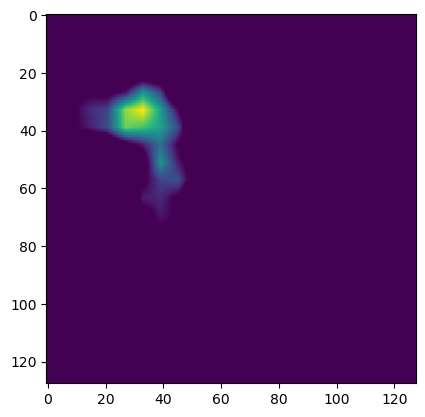

In [82]:
LAYER_NAME = 'conv2'
img_num = 8 #total 59 images, 0-58
image= X_test[img_num]
#resized_img=image[:,:,:,0]

io_img=tf.expand_dims(image, axis=0)
score_cam = ScoreCam(classification_model, io_img, LAYER_NAME)
print(score_cam.shape)

plt.imshow(score_cam[:,:,35])
plt.show()

1/1 [==============================] - 0s 91ms/step
(32,)
(128, 128, 64)


Text(0.5, 1.0, 'Overlay')

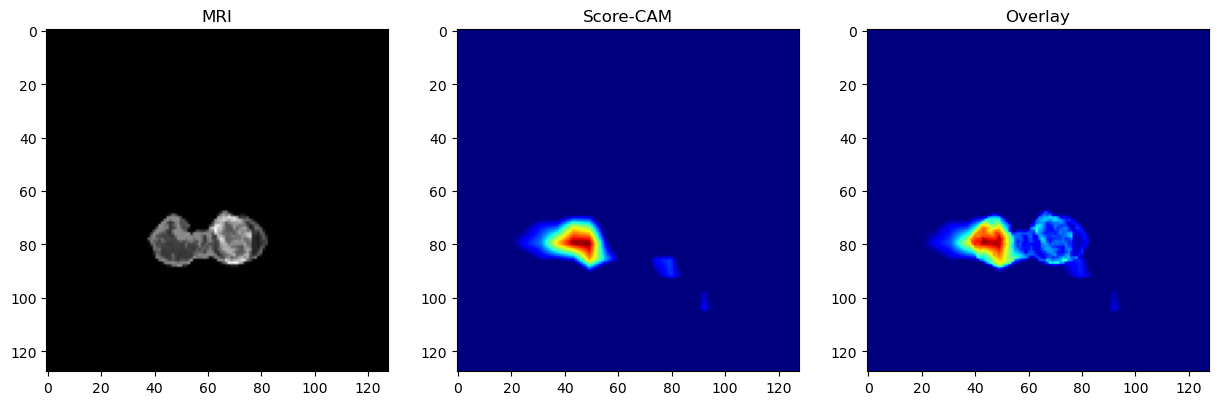

In [100]:
LAYER_NAME = 'conv2'
img_num = 0 #total 59 images, 0-58
image= X_test[img_num]
resized_img=image[:,:,:,0]

io_img=tf.expand_dims(image, axis=0)
heatmap = ScoreCam(classification_model, io_img, LAYER_NAME, max_N=-1)
print(heatmap.shape)
f, axarr = plt.subplots(1,3,figsize=(15,5));

## To move heatmap right-left, up-down
M2 = np.float32([[1, 0, 10], [0, 1, 10]])

## warpAffine does appropriate shifting given the translation matrix.
#axial_grad_cmap_img2 = cv2.warpAffine(axial_grad_cmap_img, M1, (64, 128))

coronal_ct_img=np.squeeze(resized_img[:, :, 18]) #to view slice number 18; total slices 64, 0-63
coronal_ct_img2=np.squeeze(resized_img[:, :, 45]) #slice number 26 overlapping slice 18
coronal_ct_img3=np.squeeze(resized_img[:, :, 54])  
coronal_ct_img4=np.squeeze(resized_img[:, :, 48])  
coronal_ct_img5=np.squeeze(resized_img[:, :, 35])  #slice number 35 overlapping slice 18, 26, 54, 48

coronal_grad_cmap_img = np.squeeze(heatmap[:, :, 35]) #to view heatmap for slice number 35

##############################################################################################################
## uncomment below to apply the heatmap movement as specified by "M2"
coronal_grad_cmap_img = cv2.warpAffine(coronal_grad_cmap_img, M2, (128, 128))


img_overlay=cv2.addWeighted(coronal_ct_img, 0.5, coronal_ct_img2, 0.5, 0)
img_overlay=cv2.addWeighted(coronal_ct_img5, 0.3, img_overlay, 0.5, 0)

img_plot = axarr[0].imshow(img_overlay, cmap='gray');
axarr[0].axis('on')
axarr[0].set_title('MRI')

img_plot = axarr[1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1].axis('on')
axarr[1].set_title('Score-CAM')
    
Coronal_overlay3=cv2.addWeighted(coronal_grad_cmap_img, 0.5, img_overlay, 0.5, 0)

    
img_plot = axarr[2].imshow(Coronal_overlay3,cmap='jet');
axarr[2].axis('on')
axarr[2].set_title('Overlay')